In [1]:
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import ProduceNewMasks as msk
import ProcessSegMask as atr
import csv
import time

In [2]:
local = 1
SaveFolder = 'masks-ade-4'


In [3]:
Ade_subset = pd.read_csv("../Ade20K_labels/Ade20K_labels_local_scene_subset.txt")

In [11]:
obj_count_byscene = pd.DataFrame({'countOcc': Ade_subset.groupby(['object','scene']).object.count()})

In [15]:
obj_count_byscene.index.get_level_values(0)

Index(['airplane', 'airplane', 'airplane', 'airplane', 'airplane', 'airplane',
       'airplane', 'airplane', 'airplane', 'airplane',
       ...
       'vase', 'vase', 'vase', 'vase', 'vase', 'vase', 'vase', 'vase', 'vase',
       'vase'],
      dtype='object', name='object', length=7532)

In [16]:
#Reorganize indexing, since output is a multiindex dataframe
obj_count_byscene['scene']=obj_count_byscene.index.get_level_values(1)

In [17]:
obj_count_byscene.index = obj_count_byscene.index.get_level_values(0)

In [5]:
scene_count = obj_count_byscene.set_index('scene')
scene_count['object'] = obj_count_byscene.index

In [18]:
obj_count_byscene.head()

,countOcc,scene
object,,
airplane,9,air_base
airplane,7,airfield
airplane,13,airport/airport
airplane,1,airport_terminal
airplane,1,amusement_park


In [ ]:
for obj in tqdm(np.unique(obj_count_byscene.index)):
    print(obj)

In [139]:
len(np.unique(Ade_subset['filename']))

19621

In [140]:
obj_count_byscene = pd.DataFrame({'countOcc': Ade_subset.groupby(['object','scene']).object.count()})
obj_count_byscene

countOcc
object   scene                     
airplane air_base                 9
         airfield                 7
         airport/airport         13
         airport_terminal         1
         amusement_park           1
...                             ...
vase     waiting_room            17
         wet_bar                  8
         window_seat              5
         youth_hostel             2
         ~not labeled            65

[7532 rows x 1 columns]

In [141]:
obj_count_byscene['scene']=obj_count_byscene.index.get_level_values(1)

obj_count_byscene.index = obj_count_byscene.index.get_level_values(0)


In [142]:
obj_count_byscene

,countOcc,scene
object,,
airplane,9,air_base
airplane,7,airfield
airplane,13,airport/airport
airplane,1,airport_terminal
airplane,1,amusement_park
...,...,...
vase,17,waiting_room
vase,8,wet_bar
vase,5,window_seat


In [143]:
# scene_count = pd.DataFrame({'countOcc':Ade_subset.groupby(['scene']).scene.count()})

In [144]:
# scene_count.head()
# scene_count['object'] = scene_count.index.get_level_values(1)
# scene_count.index = scene_count.index.get_level_values(0)

In [145]:
# scene_count

In [146]:
# sc_by_cat = scene_count[scene_count.index.get_level_values(0)=='abbey']

In [147]:
# sc_by_cat = pd.DataFrame({'countOcc':Ade_subset.groupby(['scene','object']).scene.count()})

In [148]:
# sc_by_cat

In [149]:
# sc_by_cat[sc_by_cat.index.get_level_values(1) == 'bench'].countOcc

In [153]:
# sc_by_cat['object'] = sc_by_cat.index.get_level_values(1)
# sc_by_cat.index = sc_by_cat.index.get_level_values(0)

In [155]:
scene_count = obj_count_byscene.set_index('scene')

In [156]:
scene_count['object'] = obj_count_byscene.index

In [158]:
sc_by_cat = scene_count[scene_count.index == 'air_base']

In [159]:
nImages = int(sc_by_cat[sc_by_cat['object'] == 'airplane'].countOcc)

In [160]:
nImages

9

In [161]:
newdf = pd.DataFrame()
missing = pd.DataFrame()
missobj = [] 
misssc = []
misscount = []
for obj in tqdm(np.unique(obj_count_byscene.index)):
#     print(obj)
    thisobj = obj_count_byscene.loc[obj]
#     print(thisobj)
    
    #eliminate all of this object occcurrences
    Ade_NoObj = Ade_subset[Ade_subset['object'] != obj]
    
    #eliminate all images that contain this object
    ListFiles = np.unique(Ade_subset[Ade_subset['object'] == obj].filename)
    Ade_NoObj = Ade_NoObj[~Ade_NoObj.filename.isin( ListFiles)]
    
    #group by the remaining things
    Ade_NoObj = pd.DataFrame({'countob' : Ade_NoObj.groupby(['filename','scene','filepath']).scene.count()})
    Ade_NoObj['filepath'] = Ade_NoObj.index.get_level_values(2)
    Ade_NoObj['scene'] = Ade_NoObj.index.get_level_values(1)
    Ade_NoObj.index = Ade_NoObj.index.get_level_values(0)
#     print('ready')
    for sc in thisobj['scene']:
        
        sc_by_cat = scene_count[scene_count.index==sc]
        nImages = int(sc_by_cat[sc_by_cat['object'] == obj].countOcc)
        if len(Ade_NoObj[Ade_NoObj['scene']==sc]) == 0:
            missobj.append(obj)
            misssc.append(sc)
            misscount.append(nImages)
            
#             print('no replacement images for this object and this scene:', obj, sc)
            continue
        elif nImages < len(Ade_NoObj[Ade_NoObj['scene']==sc]):
            newsample = Ade_NoObj[Ade_NoObj['scene']==sc].sample(nImages)
        else:
            newsample = Ade_NoObj[Ade_NoObj['scene']==sc].sample(nImages,replace=True)
        newsample = newsample.assign(objectCat = obj)
        newsample = newsample.assign(scene = sc)
        newdf = newdf.append(newsample)
#             newdf.append(Ade_NoObj[Ade_NoObj['scene']==sc].sample(nImages))
missing_items = pd.DataFrame(
    {'object': missobj,
     'scene': misssc,
     'countObj': misscount
    })            


100%|██████████| 81/81 [00:56<00:00,  1.42it/s]


In [162]:
newdf = newdf.reset_index()
newdf = newdf[["objectCat", "filepath", "filename",'scene']]
newdf = newdf.rename(columns={"objectCat": "object"})           
newdf.to_csv('../Ade20K_labels/Ade20K_labels_local_scene_subset_resampled.txt')   

In [127]:
missing_items.to_csv('../Ade20K_labels/missingItems_resampled.txt')

In [128]:
# missing_items = missing_items.set_index('object')

In [129]:
countMissing = pd.DataFrame({'countObj': missing_items.groupby('object').object.count()})

In [130]:
countCats = pd.DataFrame({'countObj': Ade_subset.groupby('object').object.count()})

In [131]:
countcats_all = countMissing.merge(countCats, left_index = True, right_index=True, how='inner')
countcats_all.head()

,countObj_x,countObj_y
object,,
airplane,2,146
armchair,2,1296
bathtub,1,504
bed,1,2091
bench,13,703


In [132]:
countcats_all['percent'] = countcats_all['countObj_x']/countcats_all['countObj_y']

In [133]:
import pylab as P


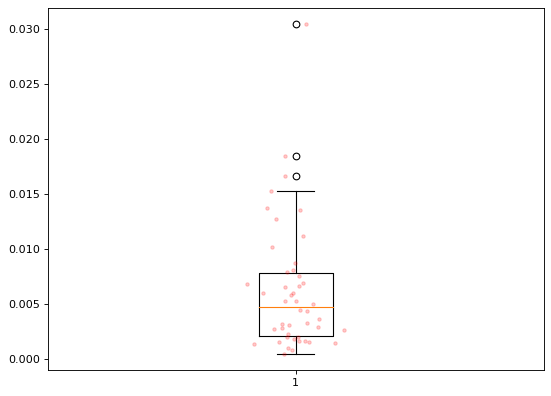

In [134]:
P.figure(figsize=(8, 6), dpi=80)
bp = P.boxplot(countcats_all['percent'])
y = countcats_all['percent']
x = np.random.normal(1, 0.04, size=len(y))
P.plot(x, y, 'r.', alpha=0.2)
P.show()

In [1]:
newdf

NameError: name 'newdf' is not defined